In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import pandas as pd
import os

In [3]:
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as T
import torchvision.datasets as datasets
from torch.utils.data import Dataset
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import torchvision.models as models
import os
from tqdm import tqdm

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

CUDA is available. Using GPU.


In [5]:
class ConvBlock(nn.Module):
  # helper module that consists of a Conv -> BN -> ReLU
  def __init__(self, in_channels, out_channels, padding=1, kernel_size=3, stride=1, with_nonlinearity=True):
    super().__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, padding=padding, kernel_size=kernel_size, stride=stride)
    self.bn = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU()
    # with_nonlinearity is a boolean flag indicating whether to include the ReLU activation.
    self.with_nonlinearity = with_nonlinearity

  def forward(self, x):
    x = self.conv(x)
    x = self.bn(x)
    if self.with_nonlinearity:
        x = self.relu(x)
    return x

In [6]:
# bridge between the downsampling part with the upsampling part
class Bridge(nn.Module):
    """
    A module serving as a bridge between the downsampling and upsampling parts of a network.
    It consists of two consecutive ConvBlocks.

    Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.bridge = nn.Sequential(
          ConvBlock(in_channels, out_channels),
          ConvBlock(out_channels, out_channels)
        )

    def forward(self, x):
        return self.bridge(x)

In [7]:
resnet = torchvision.models.resnet.resnet50(pretrained=True)
vgg = torchvision.models.vgg16(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 160MB/s] 
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed 

In [8]:
# list(vgg.features.children())

In [9]:
down_blocks = []
for layer in resnet.children():
    if isinstance(layer, nn.Sequential):
        down_blocks.extend(bottleneck for bottleneck in layer)

In [10]:
class Encoder(nn.Module):
    def __init__(self, in_channels, pretrained=True):
        super(Encoder, self).__init__()
        resnet = torchvision.models.resnet.resnet50(pretrained=True)
        down_blocks = []
        
        self.input_layer = nn.Conv2d(in_channels, 256, kernel_size=7, stride=2, padding=3, bias=False)
        
        for layer in resnet.children():
            if isinstance(layer, nn.Sequential):
                down_blocks.extend(bottleneck.to(device) for bottleneck in layer)
        
        self.down_blocks = down_blocks[1:]  # Getting rid of the first layer
        self.brid = Bridge(2048, 2048).to(device)

    def forward(self, x):
        intermediate_outputs = dict()
        
        x = self.input_layer(x)
        intermediate_outputs['input_layer'] = x.clone()
        
        for i, layer in enumerate(self.down_blocks):
            x = layer(x)
            intermediate_outputs[f"DownLayer{i}"] = x.clone()
        
        x = self.brid(x)
        intermediate_outputs['Post_Bridge'] = x.clone()
        return x, intermediate_outputs

In [11]:
in_channels = 8
height = 256
width = 192
rand = torch.rand(1, in_channels, height, width).to(device)

In [12]:
encoder = Encoder(in_channels).to(device)

In [13]:
output = encoder(rand)
output[0].shape, type(output[1])

(torch.Size([1, 2048, 16, 12]), dict)

In [14]:
# for key, value in output[1].items():
#     print(f"{key} -- {value.size()}")

In [15]:
class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Decoder, self).__init__()
        
        self.upsample9 = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels=1024, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True)
        )

        self.upsample5 = nn.Sequential(
            nn.ConvTranspose2d(1024 + 1024, 512, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        self.upsample1 = nn.Sequential(
            nn.ConvTranspose2d(512 + 512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.upsample_fin = nn.ConvTranspose2d(256 + 256, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1)

    def forward(self, x, encoder_intermediates):
        x = self.upsample9(x)
        x = torch.cat((x, encoder_intermediates["DownLayer11"]), dim=1)

        x = self.upsample5(x)
        x = torch.cat((x, encoder_intermediates["DownLayer5"]), dim=1)

        x = self.upsample1(x)
        x = torch.cat((x, encoder_intermediates["DownLayer1"]), dim=1)

        x = nn.Sigmoid()(self.upsample_fin(x))
        return x

In [16]:
decoder = Decoder(2048, 8).to(device)
decoder_out = decoder(output[0], output[1])

In [17]:
decoder_out.size()

torch.Size([1, 8, 256, 192])

In [18]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        self.encoder = Encoder(in_channels).to(device)
        self.decoder = Decoder(2048, out_channels).to(device) # 2048 channels output from the Encoder

    def forward(self, x):
        # forward pass through the encoder        
        x, encoder_outputs = self.encoder(x)

        # forward pass through the decoder with encoder's intermediate outputs
        decoder_output = self.decoder(x, encoder_outputs)
        
        return decoder_output

In [19]:
dummyunet = UNet(23,3).to(device)
rand = torch.rand(1, 23, 256, 192).to(device)
u_out = dummyunet(rand)
u_out.shape

torch.Size([1, 3, 256, 192])

In [20]:
class Discriminator(nn.Module):
    def __init__(self, input_channels):
        super(Discriminator, self).__init__()
        
        # additional layers to reduce input channels
        self.conv1 = nn.Conv2d(input_channels, 6, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(6)
        self.relu1 = nn.ReLU(inplace=True)
        
        self.conv2= nn.Conv2d(6, 3, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(3)
        self.relu2= nn.ReLU(inplace=True)
        # pre-trained ResNet50
        self.resnet50 = models.resnet50(pretrained=True)
        
        # freeze all layers
        for param in self.resnet50.parameters():
            param.requires_grad = False
            
        # unfreeze layer4 of ResNet50
        for param in self.resnet50.layer4.parameters():
            param.requires_grad = True
        
        # modify the final layer for binary classification
        num_ftrs = self.resnet50.fc.in_features
        self.resnet50.fc = nn.Linear(num_ftrs, 1)
        
        for param in self.resnet50.fc.parameters():
            param.requires_grad = True
        
        # sigmoid activation for binary classification
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        # additional layers
        x = self.conv1(x)
        x=self.bn1(x)
        x = self.relu1(x)
        
        
        x=self.conv2(x)
        x=self.bn2(x)
        x=self.relu2(x)
        
        # forward pass through ResNet50
        x = self.resnet50(x)
                          
#         # apply sigmoid activation
#         x = self.sigmoid(x)  removing sigmoid, using WGAN, critic instead of probability
        
        return x

## Mask Inpainting
We need to fully maintain the untargeted body parts as well as adaptively preserve the changeable body part (i.e. arms)


In [21]:
def one_hot_encode(labels, class_values):
    """
    Perform one-hot encoding on segmentation labels.

    Args:
        labels (torch.Tensor): Tensor containing label values.
        class_values (list): List of unique class values.

    Returns:
        torch.Tensor: One-hot encoded tensor with channels corresponding to each class.
    """
    one_hot_labels = torch.zeros(len(class_values), *labels.shape[1:])

    for i, class_value in enumerate(class_values):
        one_hot_labels[i] = (labels == class_value).float()

    return one_hot_labels

In [22]:
label_values = [0.0, 1.0, 2.0, 3.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0]

In [23]:
def crop_image(img_np, height, width):
    """
    Crops an image to a specified height and width without maintaining the aspect ratio.

    Args:
      img_np: A NumPy array representing the image.
      height: The desired height of the cropped image.
      width: The desired width of the cropped image.

    Returns:
      A NumPy array representing the cropped image.

    Raises:
      ValueError: If the desired height or width is larger than the original image dimensions.
    """

    height_orig, width_orig = img_np.shape[:2]

    if height > height_orig or width > width_orig:
      raise ValueError("Desired height or width cannot be larger than the original image dimensions.")

    start_x = (width_orig - width) // 2
    end_x = start_x + width
    start_y = (height_orig - height) // 2
    end_y = start_y + height

    return img_np[start_y:end_y, start_x:end_x]

In [24]:
def openimage(path,mode=0):
    if mode==1:
        return np.expand_dims(np.array(Image.open(path).convert("L")),axis=-1)  
        # opens in grayscale, we need to open each posemap in b/w
    else:
        return(np.array(Image.open(path)))

In [25]:
class CFMDataset(Dataset):
    def __init__(self, mode, transforms=None):
        super().__init__()
        if mode[:2].lower()=="te":
            base_dir="/kaggle/input/acgpn-dataset/ACGPN_testdata/test_"
        else:
            base_dir="/kaggle/input/acgpn-dataset/ACGPN_traindata/train_"
            
        # set directory paths
        
        self.img_dir = base_dir + "img/"
        self.M_w_dir = base_dir + "mask_Mw/"
        self.paint_dir = base_dir + "mask/"
        self.clothseg_dir = base_dir + "label/"
        self.transforms = transforms
        
        self.M_w = sorted(os.listdir(self.M_w_dir))
        self.images = sorted(os.listdir(self.img_dir))
        self.paints = sorted(os.listdir(self.paint_dir)) # around 12k paints
        self.clothsegs = sorted(os.listdir(self.clothseg_dir))
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self,index):       
        M_w = openimage(os.path.join(self.M_w_dir, self.M_w[index]),1)
        M_w = one_hot_encode(torch.from_numpy(M_w.transpose(2,0,1)), label_values) 
        # Mw, loading and one hot encoding, returns tensor
        M_w = M_w.numpy().transpose(1,2,0) # max = 1, min = 0, 13 channels
        
        # we get the original image of person
        image = openimage(os.path.join(self.img_dir, self.images[index]),0) # 3 channels
        rand = np.random.randint(0,len(self.images))
        real_image = openimage(os.path.join(self.img_dir, self.images[rand]),0)
        # we get the background and upclothes segments from the _label
        segments = openimage(os.path.join(self.clothseg_dir, self.clothsegs[index]),1)
        
#         background = np.where(segments == 0, 1.0, 0.0) # 1 channel, we want to keep the bg for the neck
        
#         neck=(image*background)/255  # 3 channels
        
        background = np.where(segments == 0, 0.0, 1.0) # inverted, 1 channel
        upcloth = np.where(segments == 4, 0.0, 1.0) # inverted, 1 channel
        upcloth_1 = np.where(segments == 4, 1.0, 0.0) # 1 channel
        
        # we get the paints and crop them to 256, 192
        rand = np.random.randint(0,len(self.paints)-1)
        paint = openimage(os.path.join(self.paint_dir, self.paints[rand]),1)/255
        paint = crop_image(paint,256,192)
        # paint inversion
        paint = np.where(paint > 0.5, 0, 1) # inverted, 1 channel
        
        # - image: (256, 192, 3)
        # - background: (256, 192, 1)
        # - upcloth: (256, 192, 1)
        # - upcloth_1: (256, 192, 1)
        # - paint: (256, 192,1)
        
        # removing the targeted area completely and inpainting over the non-targeted area
        combined_mask =  upcloth * paint
        I_w = (image * combined_mask)/255 # 3 channels
        
        T_cR = (image * upcloth_1)/255 # 3 channels
        
        # - I_w: (256, 192, 3)
        # - M_w: (256, 192, 13)
        # - T_cR: (256, 192, 3)
        # - upcloth_1: (256, 192, 1)
        
        combined_image = np.concatenate((I_w, M_w, T_cR, upcloth_1), axis=2) # 20 channels input
        
        input_tensor = torch.from_numpy(combined_image.transpose(2, 0, 1)).float()
        label_tensor = torch.from_numpy(image.transpose(2, 0, 1)).float()/255 # 3 channels output
        real_tensor = torch.from_numpy(real_image.transpose(2, 0, 1)).float()/255 # 3 channels
        
        return input_tensor, real_tensor, label_tensor

In [26]:
# example M_w
M_w = openimage("/kaggle/input/acgpn-dataset/ACGPN_traindata/train_mask_Mw/000006_0.png",1)
M_w = one_hot_encode(torch.from_numpy(M_w.transpose(2,0,1)), label_values) 
# Mw, loading and one hot encoding, returns tensor
M_w = M_w.numpy().transpose(1,2,0) # max = 1, min = 0

In [27]:
M_w.shape

(256, 192, 13)

In [28]:
tf= T.Compose(
        [
            T.ToTensor(),
        ]
    )

In [29]:
MODE= "TRAIN" # use "TEST" for traning, once ACGPN dataset has all test directories ready
BATCH_SIZE= 8

In [30]:
dataset = CFMDataset(MODE,transforms=tf)

In [31]:
train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [32]:
len(train_dataloader)

1778

In [33]:
imgs, reals, labels = next(iter(train_dataloader))
imgs.shape, reals.shape,labels.shape

(torch.Size([8, 20, 256, 192]),
 torch.Size([8, 3, 256, 192]),
 torch.Size([8, 3, 256, 192]))

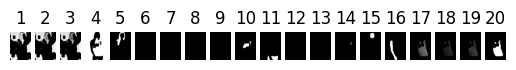

In [37]:
for channel in range(imgs.size(1)):
    plt.subplot(1, 20, channel + 1)
    plt.imshow(imgs[1, channel].cpu(), cmap='gray')
    plt.title(f'{channel + 1}')
    plt.axis('off')
plt.show()

In [38]:
img= imgs[0]
img.shape

torch.Size([20, 256, 192])

In [39]:
img=img[:3]
img.shape

torch.Size([3, 256, 192])

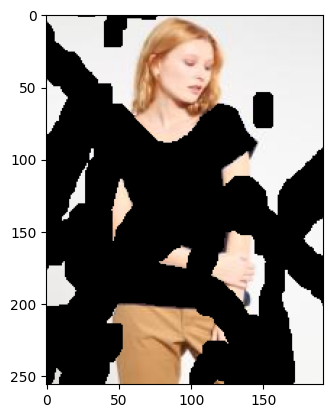

In [40]:
img= img.numpy()
img= np.transpose(img, (1,2,0))
plt.imshow(img)

yup good


## VGG Loss

In [41]:
class VGGPerceptualLoss(nn.Module):
    """
    Calculate the perceptual loss between two images using VGG feature maps.

    This class takes two images/feature maps, computes their respective VGG feature maps at specified layers,
    and calculates the Mean Squared Error (MSE) loss between these feature maps.

    Args:
        feature_extractor (function): A feature extractor used to extract feature maps from input images.
        diction (dict): A dictionary specifying the layers from which feature maps are extracted.
                       Keys are layer numbers and values are corresponding layer sequences in the
                       feature extractor network.
        criterion (torch.nn.modules.loss) : The loss function for inter-layer loss.
        lambdas (dict) : The dictionary that stores the weights for weighted addition of losses.

    Methods:
        forward(x, y):
            Computes the perceptual loss between two images.

    """
    def __init__(self, feature_extractor, diction, criterion, lambdas):
        super(VGGPerceptualLoss, self).__init__()
        self.feature_extractor = feature_extractor
        self.diction = diction
        self.criterion = criterion
        self.lambdas = lambdas

    def forward(self, x, y):
        x_features = self.feature_extractor(x,self.diction)
        y_features = self.feature_extractor(y,self.diction)
#         print(len(x_features), len(y_features))
        loss = 0
        for layer_name,_ in self.diction.items():
            x_feat = x_features[layer_name]
            y_feat = y_features[layer_name]
            
            loss += self.lambdas[layer_name] * self.criterion(x_feat, y_feat)        
        return loss

In [42]:
features = list(vgg.features.children())[:28]
features = nn.Sequential(*features)
layers = {'6':'6','15':'15','27':'27'}
vgg_feature_extractor = {'6': features[:7], '15': features[7:16], '27': features[16:]}
lambdas = {'6': 0.3, '15': 0.3, '27': 0.4}
features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [43]:
def feature_extractor(x, dic):
    """
    Takes a torch tensor x as input and passes them through the corresponding layers
    in the dictionary.
    
    Args:
        x (torch.Tensor) : The input tensor.
        dic (dict) : The layers of the VGG Network saved as values to corresponding layer
                    names as keys.
    
    Returns:
        features (dict) : Keys = Layer names (str), Values = Extracted tensors (torch.Tensor)
    """
    features = {}
    for name, sequence in dic.items():
        x= sequence(x)
        features[name] = x
    
    return features   
    

In [44]:

criterion_mse = nn.MSELoss()
vgg_tester= VGGPerceptualLoss(feature_extractor, vgg_feature_extractor, criterion_mse,lambdas)

In [45]:
rand1 = torch.rand(8, 3, 256, 192)
rand2= torch.rand(8,3,256,192)

In [46]:
vgg_loss= vgg_tester.forward(rand1,rand2)
print(type(vgg_loss), vgg_loss)

<class 'torch.Tensor'> tensor(1.0543, grad_fn=<AddBackward0>)


In [47]:
vgg_tester.forward(reals[0],reals[0])

tensor(0., grad_fn=<AddBackward0>)

In [48]:
discriminator = Discriminator(3).to(device)

# discriminator.load_state_dict(torch.load("/kaggle/input/latestweights/D3W_weights_10epochs.pth"))
discriminator.load_state_dict(torch.load("/kaggle/input/latestweights/D3W_weights_10epochs.pth"))

rand = torch.rand(1, 3, height, width).to(device)
disout = discriminator(rand)
disout.shape

torch.Size([1, 1])

In [49]:
imgs=imgs.to(device)
labels=labels.to(device)
reals= reals.to(device)

In [50]:
generator = UNet(20, 3).to(device) #20 in_channels and 1 out_channels
generator.load_state_dict(torch.load("/kaggle/input/latestweights/G3W_weights_10epochs.pth"))

<All keys matched successfully>

In [51]:
criterion_bce = nn.BCELoss()
criterion_pixelwise = nn.CrossEntropyLoss()
criterion_mse = nn.MSELoss()


In [52]:
# features = list(vgg.features.children())[:28]
# features = nn.Sequential(*features)
# layers = {'6':'6','15':'15','27':'27'}
# vgg_dic = {'6': features[:6], '15': features[:15], '27': features}
# lambdas = {'6': 0.2, '15': 0.3, '27': 0.5}

features = list(vgg.features.children())[:28]
features = nn.Sequential(*features)
layers = {'6':'6','15':'15','27':'27'}
vgg_feature_extractor = {'6': features[:7].to(device), '15': features[7:16].to(device), '27': features[16:].to(device)}
lambdas = {'6': 0.3, '15': 0.3, '27': 0.4}

In [53]:
criterion_vgg = VGGPerceptualLoss(feature_extractor, vgg_feature_extractor, criterion_mse,lambdas).to(device)

In [54]:
criterion_vgg.forward(reals[0], reals[1])

tensor(2.0049, device='cuda:0', grad_fn=<AddBackward0>)

In [55]:
# testing criterion_vgg
generated_image = torch.randn(1, 3, 256, 192)  # Example generated image
target_image = torch.randn(1, 3, 256, 192)     # Example target image
generated_image = generated_image.to(device)
target_image = target_image.to(device)
loss = criterion_vgg(generated_image, target_image)
loss

tensor(5.8651, device='cuda:0', grad_fn=<AddBackward0>)

In [60]:
imgs, reals, labels = next(iter(train_dataloader))
imgs=imgs.to(device)
labels=labels.to(device)
reals= reals.to(device)
fixed_sample= imgs

fixed_sample.shape

torch.Size([8, 20, 256, 192])

In [61]:
sample_out= generator(fixed_sample)
sample_out.shape

torch.Size([8, 3, 256, 192])

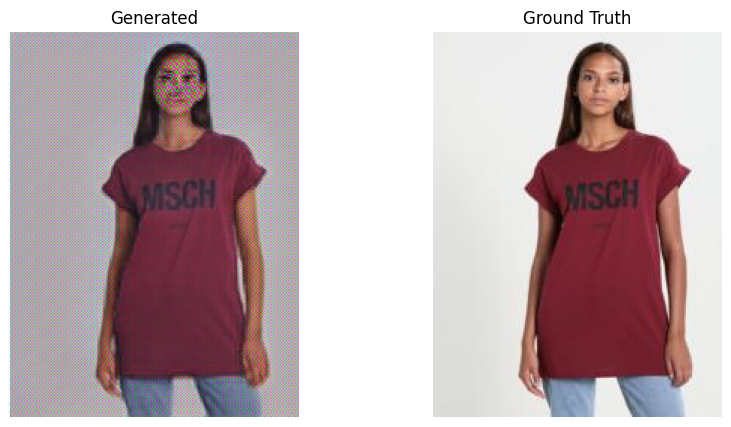

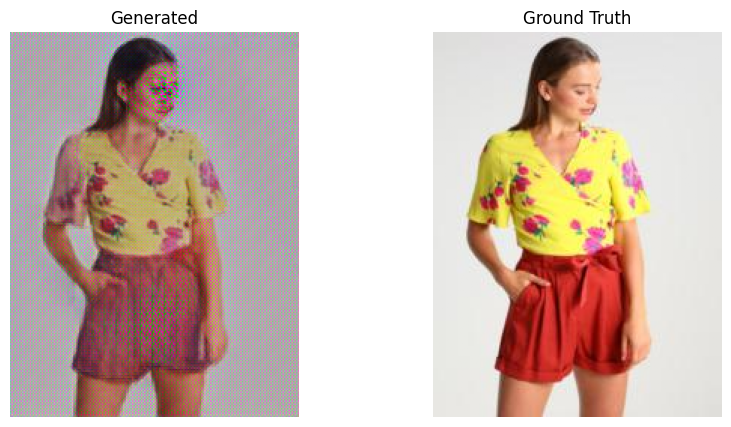

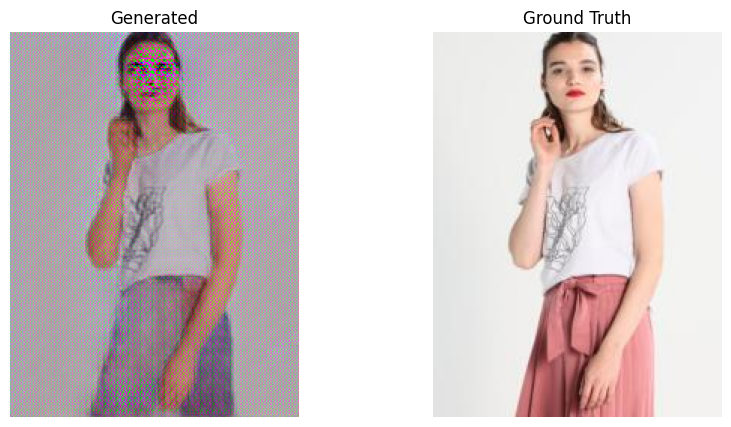

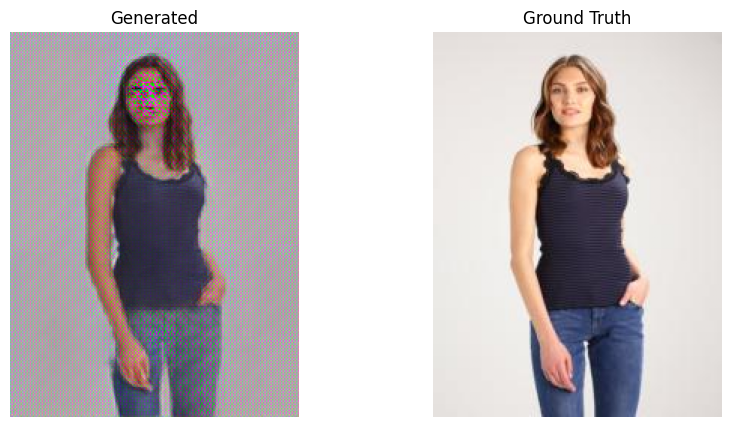

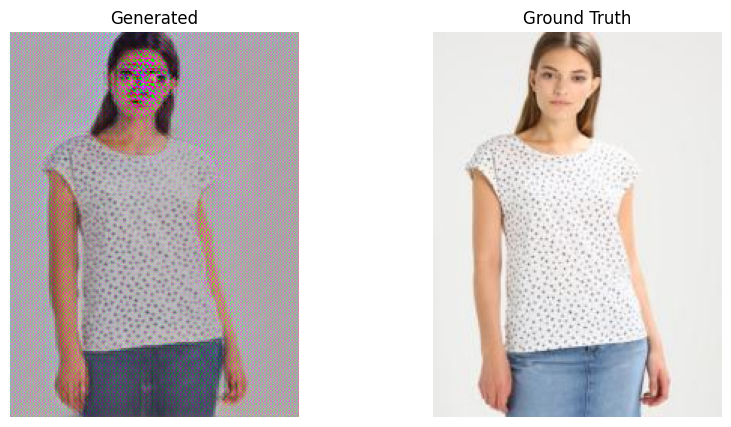

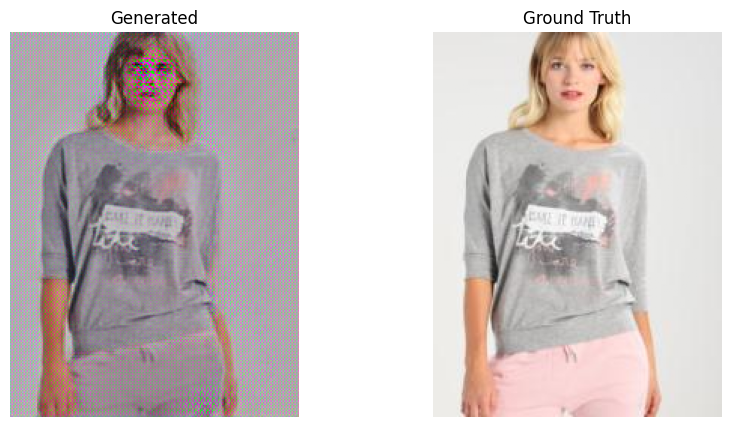

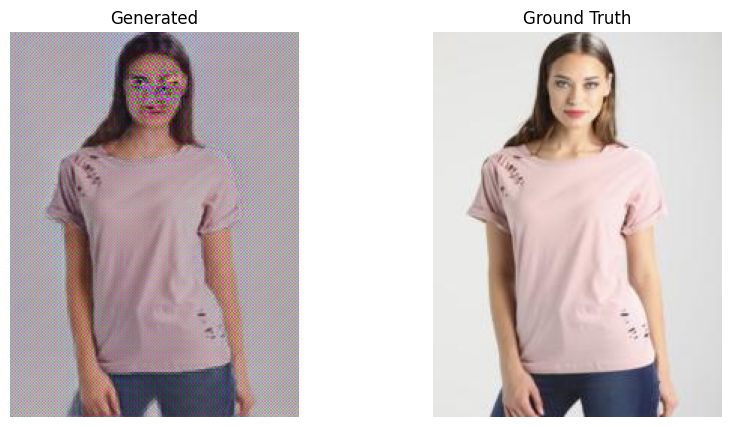

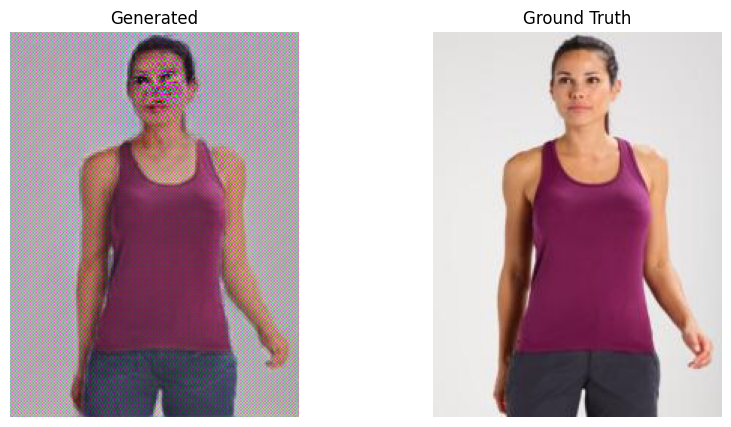

In [62]:
# sample_out= sample_out.cpu().detach().numpy()
for i in range(len(sample_out)):
    toplot= sample_out[i].cpu().detach().numpy()
    toplot= np.transpose(toplot,(1,2,0))

    label=labels[i].cpu().detach().numpy()
    label= np.transpose(label,(1,2,0))
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(toplot)
    axes[0].set_title('Generated')
    axes[0].axis('off')
    axes[1].imshow(label)
    axes[1].set_title('Ground Truth')
    axes[1].axis('off')
    plt.show()


In [63]:
lr = 0.00001

epochs =  2
lambda1 = 0.1
lambda2 = 1
lambda3 = 1

In [64]:
weights_dir = "/kaggle/working/"
generator_weights_path = os.path.join(weights_dir, 'G3W_weights_10epochs.pth')
# torch.save(generator.state_dict(), generator_weights_path)
# print(f"Generator weights saved to: {generator_weights_path}")

weights_dir = "/kaggle/working/"
discriminator_weights_path = os.path.join(weights_dir, 'D3W_weights_10epochs.pth')
# torch.save(discriminator.state_dict(), discriminator_weights_path)
# print(f"Discriminator weights saved to: {discriminator_weights_path}")

In [65]:
# optimizer_g = torch.optim.Adam(generator.parameters(), lr=lr, betas = (0.9, 0.999))
# optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas = (0.9, 0.999))
optimizer_d = optim.RMSprop(discriminator.parameters(), lr = lr)
optimizer_g= optim.RMSprop(generator.parameters(), lr = lr)

In [67]:
total_iterations = len(train_dataloader)

In [ ]:
for epoch in range(epochs):
    for i,data in enumerate(train_dataloader):
        if i>1770:
            break
        
        inputs, reals, finals = data
        # send to device
        inputs = inputs.to(device)
        reals = reals.to(device)
        finals = finals.to(device)
        
        for _ in range(5):
            
            # training discriminator
            # clear discriminator gradients
            optimizer_d.zero_grad()

            # pass real images through discriminator
            real_preds = discriminator(reals)
#             real_targets = torch.ones(inputs.size(0), 1, device=device)

#             real_loss = criterion_bce(real_preds, real_targets)  # calculate loss for real images
            errD_real = -torch.mean(real_preds)
            
            # generate fake images
            fakes = generator(inputs)

            # pass fake images through discriminator
            fake_preds = discriminator(fakes)
#             fake_targets = torch.zeros(fakes.size(0), 1, device=device)
#             fake_loss = criterion_bce(fake_preds, fake_targets) # calculate loss for generated images
            
            errD_fake = torch.mean(fake_preds)
            errD = errD_fake + errD_real
            
            errD.backward()
            optimizer_d.step()
            
            with torch.no_grad():
                for name, param in discriminator.named_parameters():
                    if 'batch' not in name:
                        param.clamp_(-0.01,0.01)

        
#             # update discriminator weights
#             disc_loss = real_loss + fake_loss
#             disc_loss.backward()
#             optimizer_d.step()      # update disc weights
        
    
        # Training generator
        # clear generator gradients
        optimizer_g.zero_grad()

        # generate fake images
        
        # latent = torch.randn(BATCH_SIZE, latent_size, 1, 1, device=device)
        fakes = generator(inputs)
        # try to fool the discriminator
        
        preds = discriminator(fakes)
        
        recon_loss = criterion_vgg(fakes, finals)
        
        errG = -torch.mean(preds) + recon_loss
        errG.backward()
        optimizer_g.step()
        
#         ce_loss = torch.nn.functional.cross_entropy(fakes, finals, reduction='mean')
        
#         targets = torch.ones(BATCH_SIZE, 1, device=device)
        
# #         print(fakes.shape,"\n",finals.shape)
        
#         recon_loss = criterion_vgg(fakes, finals)
        
#         gen_loss = criterion_bce(preds, targets) * lambda1 + ce_loss * lambda2 + recon_loss * lambda3

#         # update generator weights
#         gen_loss.backward()
#         optimizer_g.step()

        if i % 50 == 0:
            print(f"Epoch {epoch} | Batch {i} | GenLoss {errG} | DiscLoss {errD}")
            with torch.no_grad():
                # take one image sample for visualization
                sample_input = inputs[0].unsqueeze(0).to(device)
                sample_fakes = generator(sample_input)
        
            plt.imshow(sample_fakes.detach().cpu().numpy()[0].transpose(1, 2, 0))
            plt.axis('off')
            plt.show()
    
    print(f"---------epoch {epoch} ending--------\nsaving model and sample outputs")
    #saving model weights and sample outputs
    sample_out= generator(fixed_sample)
    sample_out= sample_out.cpu().detach().numpy()
    i = np.transpose(sample_out[0],(1,2,0))
    plt.imshow(i)
    plt.imsave("/kaggle/working/sample.png",i)
    
    
    #saving gen weights
    torch.save(generator.state_dict(), generator_weights_path)
    
    #saving disc weights
    torch.save(discriminator.state_dict(), discriminator_weights_path)    
    